# Importy

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from functions import add_last_position, download_in_range, dict_to_dataframe, add_standings, team_name_fixup

# Wczytywanie i bazowe uzupełnienie danych

In [2]:
dataset=download_in_range(2017, 2024)

dataset=add_last_position(dataset)
dataset=add_standings(dataset)
dataset=dict_to_dataframe(dataset)

Dane do badań pobieram za pomocą Ergast Developer API dającego dostęp do bazy danych dotyczącej wyścigów Formyły 1. Za pomocą własnej metody download_in_range pobieram dane z lat 2017-2023 i sprowadzam je do postaci słownikowej. Zdecydowałem się na pobieranie danych od 2017, gdyż od tego roku w mistrzostwach Formuły 1 bierze udział dokładnie 10 zespołów oraz dokładnie 20 kierowców. Następnie za pomocą metody add_last_position dodaję dla każdego wyścigu oraz każdego kierowcy pozycję którą zajął w poprzednim swoim wyścigu. Na końcu za pomocą dict_to_dataframe dane z postaci słownikowej przekładam do obiektu klasy DataFrame z biblioteki Pandas.

# Analiza danych

In [3]:
display(dataset)

,season,round,circuit,driver,age,constructor,standing,last_result,grid,position
0,2017,1,albert_park,vettel,30,ferrari,4,3,2,1
1,2017,1,albert_park,hamilton,32,mercedes,2,1,1,2
2,2017,1,albert_park,bottas,28,mercedes,8,20,3,3
3,2017,1,albert_park,raikkonen,38,ferrari,6,6,4,4
4,2017,1,albert_park,max_verstappen,20,red_bull,5,4,5,5
...,...,...,...,...,...,...,...,...,...,...
2915,2024,1,bahrain,hulkenberg,37,haas,16,15,10,16
2916,2024,1,bahrain,ocon,28,alpine,12,12,19,17
2917,2024,1,bahrain,gasly,28,alpine,11,13,20,18
2918,2024,1,bahrain,bottas,35,sauber,15,19,16,19


Poszczególne dane oznaczają:
season - sezon mistrzostw Formuły 1
round - runda mistrzostw
circuit - nazwa toru
driver - nazwa kierowcy
age - wiek kierowcy w pełnych latach
constructor - nazwa zespołu, dla którego jeździ kierowca
last_result - pozycja w ostatnim wyścigu kierowcy
grid - pozycja na starcie wiścigu
position - pozycja na mecie wyścigu

# Problem

Postawiony przeze mnie problem to predykcja pozycji na mecie, przy pomocy danych wyścigów Formuły 1, z wykorzystaniem znanych modeli klasyfikacji.

# Sprawdzenie poprawności danych

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   season       2920 non-null   int64 
 1   round        2920 non-null   int64 
 2   circuit      2920 non-null   object
 3   driver       2920 non-null   object
 4   age          2920 non-null   int64 
 5   constructor  2920 non-null   object
 6   standing     2920 non-null   int64 
 7   last_result  2920 non-null   int64 
 8   grid         2920 non-null   int64 
 9   position     2920 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 228.2+ KB


Dane są czyste, nie zawieraja żadnych pustych komórek, jednak zauważyłem, że w kilku miejscach pozycja startowa wynosi 0 co jest niedopuszczalne. Dodadkowo zauważyłem, że dotyczy to głównie sytuacji gdzie kierowca w kwalifikacjach uszkodził bolid lub został ukarany przez co startował z alei serwisowej co zaś jest równoznaczne ze startowaniem z końca stawki. Z tego powodu postanowiłem zamienić wszystkie wartości 0 na wartość 20.

In [5]:
has_zero = (dataset == 0).any(axis=1)
filtered_dataset = dataset[has_zero]
print(filtered_dataset)

      season  round      circuit           driver  age   constructor  \
16      2017      1  albert_park        ricciardo   28      red_bull   
299     2017     15       sepang        raikkonen   38       ferrari   
599     2018     10  silverstone  brendon_hartley   29    toro_rosso   
869     2019      3     shanghai            albon   23    toro_rosso   
889     2019      4         baku        raikkonen   40          alfa   
...      ...    ...          ...              ...  ...           ...   
2810    2023     18     americas       hulkenberg   36          haas   
2813    2023     18     americas  kevin_magnussen   31          haas   
2815    2023     18     americas           alonso   42  aston_martin   
2836    2023     19    rodriguez           stroll   25  aston_martin   
2859    2023     20   interlagos          leclerc   26       ferrari   

      standing  last_result  grid  position  
16           3            5     0        17  
299          5           20     0        20

In [6]:
for i in range(len(dataset)):
    if dataset['grid'].values[i]==0: dataset['grid'].values[i]=20

In [7]:
dataset = team_name_fixup(dataset)

# Wizualizacja danych

### Pozycja startowa

Text(0, 0.5, 'Ilość poszczególnych pozycji na mecie')

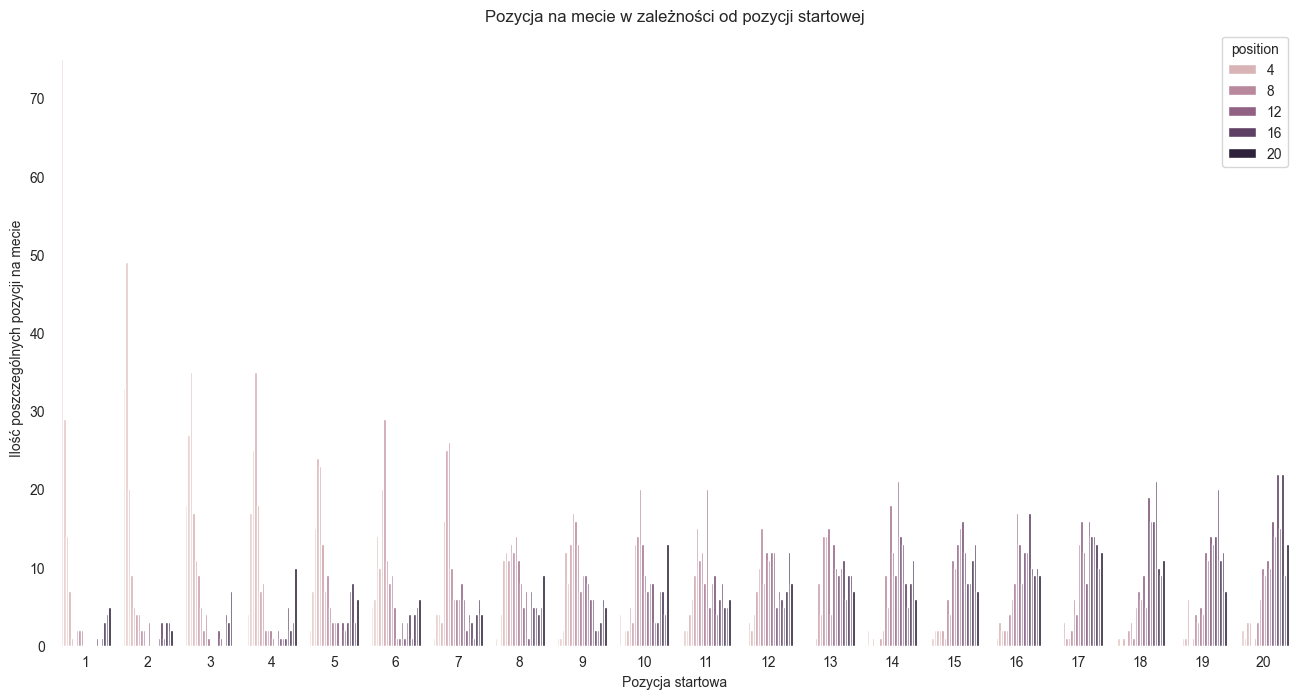

In [8]:
plt.figure(figsize=(16,8))
plt.rcParams['axes.facecolor'] = 'white'
sns.countplot(x='grid', hue='position', data=dataset)
plt.title("Pozycja na mecie w zależności od pozycji startowej")
plt.xlabel("Pozycja startowa")
plt.ylabel("Ilość poszczególnych pozycji na mecie")

Text(0, 0.5, 'Ilość poszczególnych pozycji na mecie')

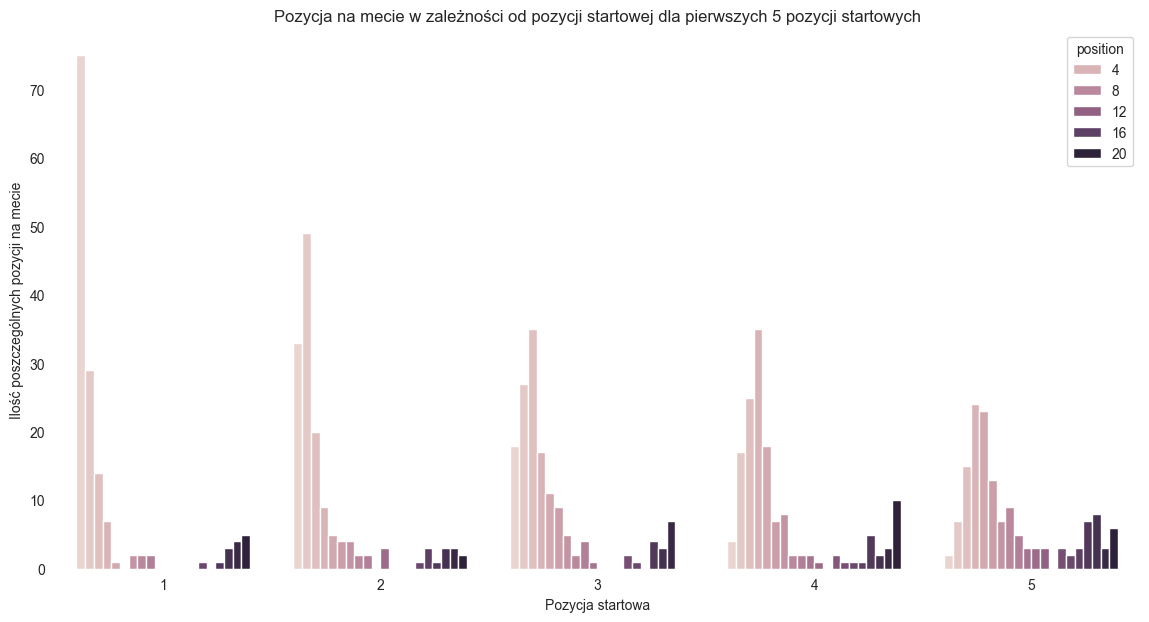

In [9]:
plt.figure(figsize=(14,7))
filtered_dataset=dataset[(dataset['grid']>=1) & (dataset['grid']<=5)]
sns.countplot(x='grid', hue='position', data=filtered_dataset)
plt.title("Pozycja na mecie w zależności od pozycji startowej dla pierwszych 5 pozycji startowych")
plt.xlabel("Pozycja startowa")
plt.ylabel("Ilość poszczególnych pozycji na mecie")

Pozycja startowa kierowcy ma bardzo duży wpływ na pozycję końcową w wyścigu. Naturalnie w większości przypadków im wyżej kierowca startuje z tym wyższą lokatą kończy. Można jednak również zauważyć, że na wyższych pozycjach jest większe prawdopodobieństwo, że kierowca skończy dokładnie na tej pozycji, na której startował.

### Pozycja w poprzednim wyścigu

Text(0, 0.5, 'Ilość poszczególnych pozycji na mecie')

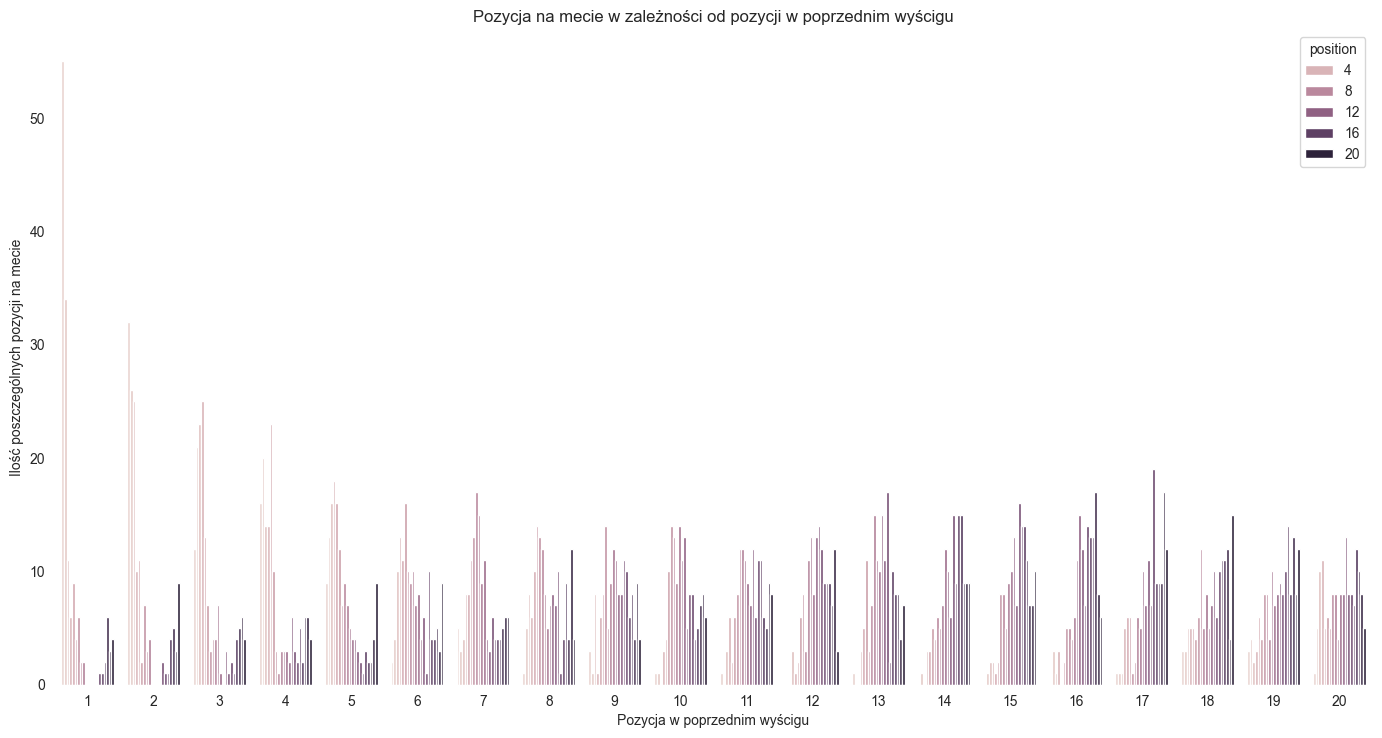

In [10]:
plt.figure(figsize=(17,8.5))
sns.countplot(x='last_result', hue='position', data=dataset)
plt.title("Pozycja na mecie w zależności od pozycji w poprzednim wyścigu")
plt.xlabel("Pozycja w poprzednim wyścigu")
plt.ylabel("Ilość poszczególnych pozycji na mecie")

Text(0, 0.5, 'Ilość poszczególnych pozycji na mecie')

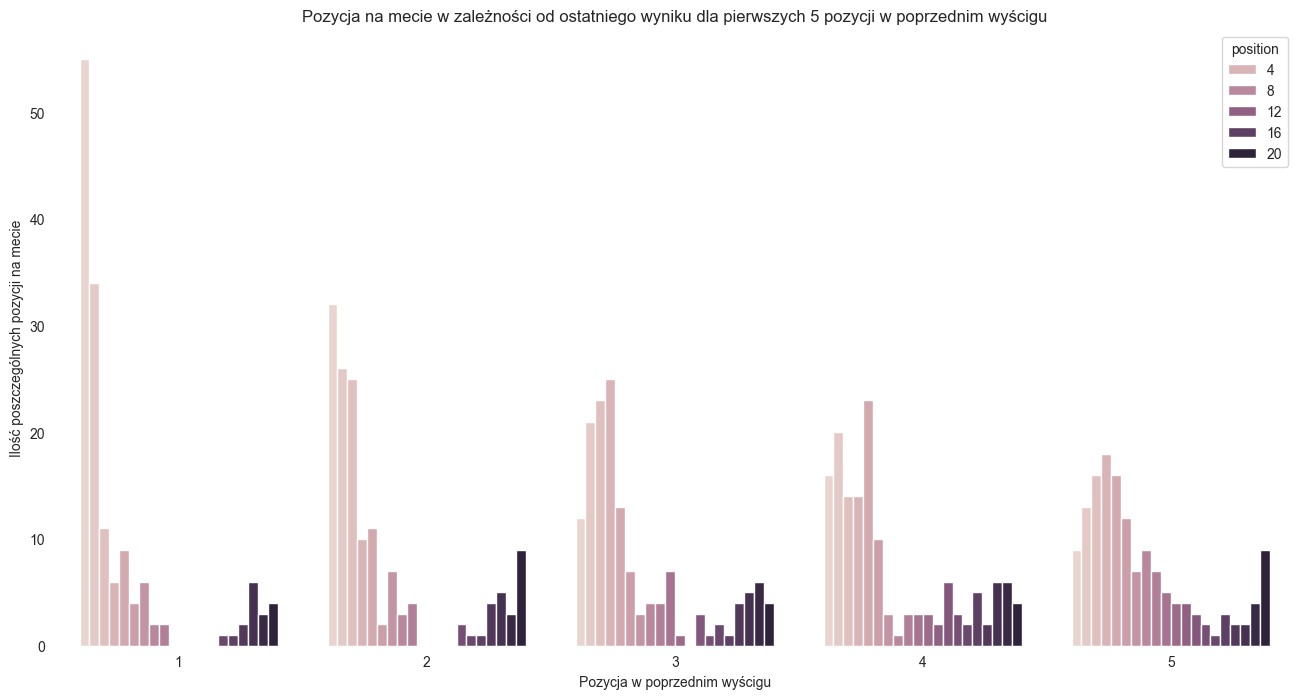

In [11]:
plt.figure(figsize=(16,8))
filtered_dataset=dataset[(dataset['last_result']>=1) & (dataset['last_result']<=5)]
sns.countplot(x='last_result', hue='position', data=filtered_dataset)
plt.title("Pozycja na mecie w zależności od ostatniego wyniku dla pierwszych 5 pozycji w poprzednim wyścigu")
plt.xlabel("Pozycja w poprzednim wyścigu")
plt.ylabel("Ilość poszczególnych pozycji na mecie")

Wykres jak można było się spodziewać jest dosyć podobny do poprzedniego. Im wyżej kierowca przyjechał w poprzednim wyścigu tym wyżej był na mecie w kolejnym.

### Pozycja w klasyfikacji

Text(0, 0.5, 'Ilość poszczególnych pozycji na mecie')

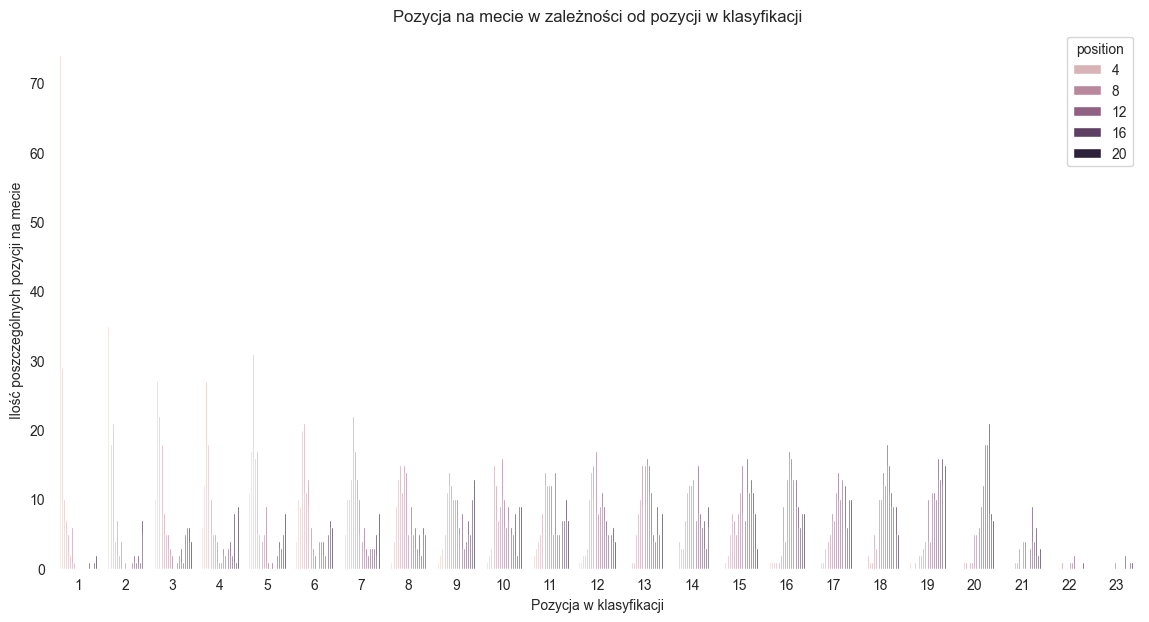

In [12]:
plt.figure(figsize=(14, 7))
sns.countplot(x='standing', hue='position', data=dataset)
plt.title("Pozycja na mecie w zależności od pozycji w klasyfikacji")
plt.xlabel("Pozycja w klasyfikacji")
plt.ylabel("Ilość poszczególnych pozycji na mecie")

Text(0, 0.5, 'Ilość poszczególnych pozycji na mecie')

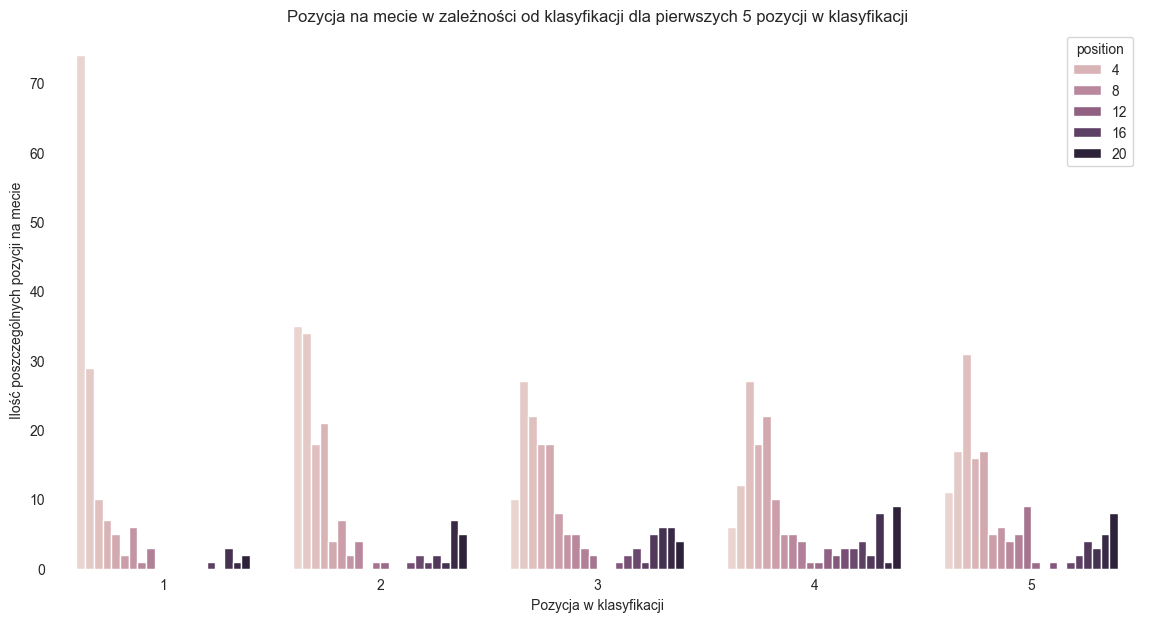

In [13]:
plt.figure(figsize=(14, 7))
filtered_dataset=dataset[(dataset['standing']>=1) & (dataset['standing']<=5)]
sns.countplot(x='standing', hue='position', data=filtered_dataset)
plt.title("Pozycja na mecie w zależności od klasyfikacji dla pierwszych 5 pozycji w klasyfikacji")
plt.xlabel("Pozycja w klasyfikacji")
plt.ylabel("Ilość poszczególnych pozycji na mecie")

### Zespół

Text(0, 0.5, 'Ilość poszczególnych pozycji na mecie')

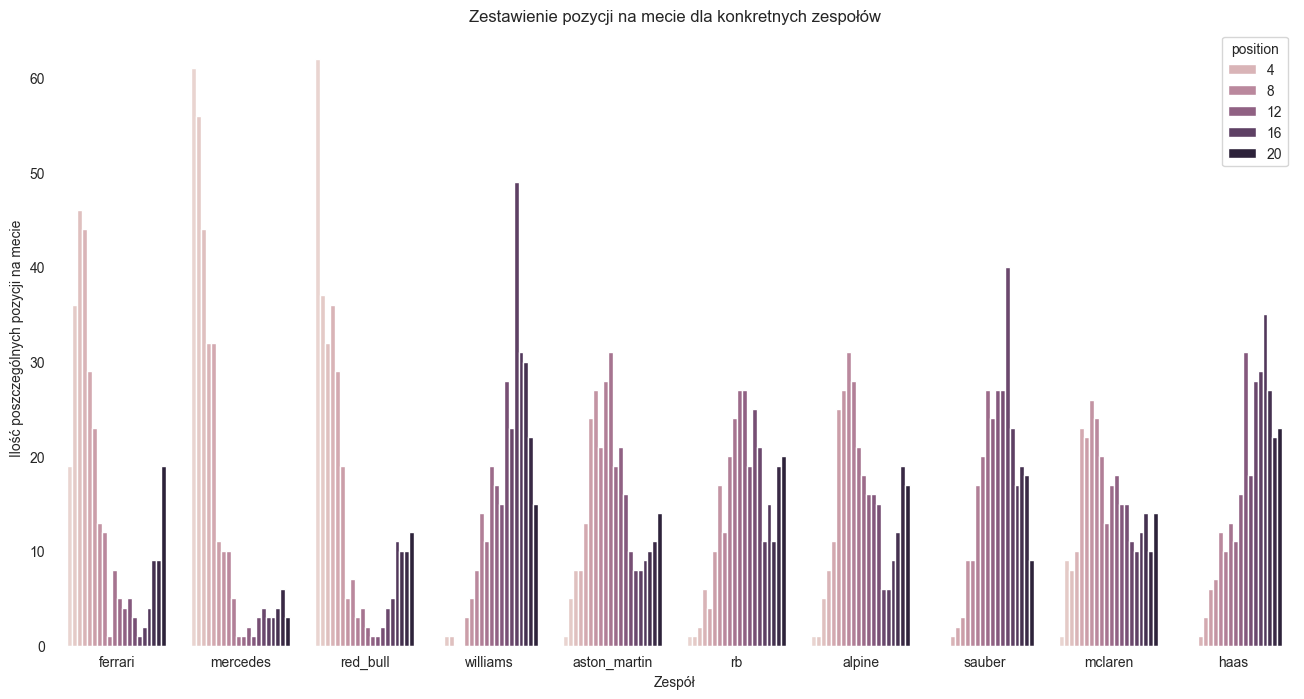

In [14]:
plt.figure(figsize=(16,8))
sns.countplot(x='constructor', hue='position', data=dataset)
plt.title("Zestawienie pozycji na mecie dla konkretnych zespołów")
plt.xlabel("Zespół")
plt.ylabel("Ilość poszczególnych pozycji na mecie")

Zespół dla którego jeżdżą kierowcy również ma duże znaczenie dla wyniku końcowego. Zespoły czołowe takie jak Ferrari, Mercedes i Red Bull zazwyczaj zajmują najwyższe lokaty. Ewentualne ich słabsze wyniki są spowodowane sytuacjami losowymi. Williams i Haas za to są najsłabszymi zespołami. Ich lepsze wyniki mogą być jedynie spowodowane słabszą dyspozycją czołówki. Niektóre zespoły mają łącznie mniej danych, gdyż pomiędzy sezonami mogą nastąpić zmiany w konstrukcji stawki, np. inny koncern przejmuje czyiś zespół lub jeden zespół upada a nowy dołącza do mistrzostw. Mimo wszystko od sezonu 2017 łączna liczba zespołów w stawce pozostaje niezmienna czyli 10.

### Wiek kierowcy

Text(0, 0.5, 'Mediana pozycji')

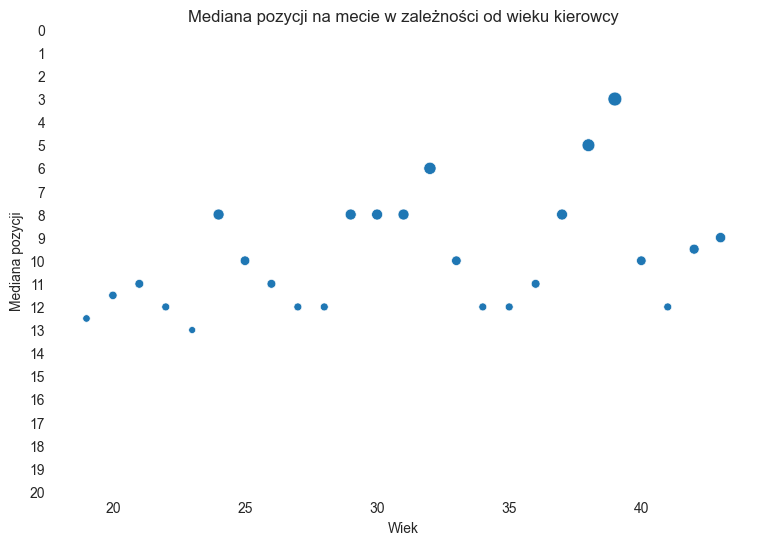

In [15]:
def median_position_for_age(dataset, ages):
    y=np.array([])
    for age in ages:
        positions=np.array([])
        for i in range(len(dataset)):
            if dataset['age'].values[i]==age: positions=np.append(positions, dataset['position'].values[i])
        y=np.append(y, np.median(positions))
    return y

plt.figure(figsize=(9,6))
X = dataset['age'].values
X_set={age for age in X}
X=np.array([age for age in X_set])
Y = median_position_for_age(dataset, X)
g=sns.scatterplot(x=X, y=Y, size=Y, sizes=(100,25), legend=False)
g.set(ylim=(20,1))
g.set_yticks(range(21))
plt.title("Mediana pozycji na mecie w zależności od wieku kierowcy")
plt.xlabel("Wiek")
plt.ylabel("Mediana pozycji")

Najwyższy środkowy wynik mają kierowcy w wieku 38 lat, najniższy zaś kierowcy w wieku 22 lat. Kierowcy w wieku średnim (30-32) jeżdżą na solidnym, stabilnym poziomie.

# Porzucanie zbędnych danych

Niektóre dane nie mają wpływu na pozycję na mecie a ich zostawienie jednynie zwiększa złożoność zbioru danych.

### season, round, circuit, driver
* season, round, circuit - są to jedynie dane porządkowe, informują z którym wyścigiem i w którym sezonie mamy do czynienia
* driver - ta dana zawiera zbyt dużo przypadków, w dodatku mogą istnieć kierowcy, którzy przejechali tylko jeden wyścig i nie da się dużo o nich powiedzieć

In [16]:
columns_to_drop = ['season', 'round', 'circuit', 'driver']
dataset.drop(columns_to_drop, axis=1, inplace=True)

# Zmiana kategorialna

Poniższa funkcja służy do dodania sztucznych kolumn dla parametrów których wartość bez odpowiedniego kontekstu nic nie mówi.

In [17]:
def create_categorical_feature(dataset, column_to_modify):
    categorical = pd.get_dummies(dataset[column_to_modify], prefix=column_to_modify)
    dataset.drop(column_to_modify, axis=1, inplace=True)
    dataset = pd.concat([dataset, categorical], axis=1)
    return dataset

### Zespół

In [18]:
dataset = create_categorical_feature(dataset, 'constructor')

### Pozycja

Od wszystkich pozycji musimy odjąć 1 tak, żeby klasy zaczynały się od 0 a kończyły na 19.

In [19]:
for i in range(len(dataset)):
    dataset['position'].values[i]-=1

### Nowy wygląd danych

In [20]:
display(dataset)

,age,standing,last_result,grid,position,constructor_alpine,constructor_aston_martin,constructor_ferrari,constructor_haas,constructor_mclaren,constructor_mercedes,constructor_rb,constructor_red_bull,constructor_sauber,constructor_williams
0,30,4,3,2,0,False,False,True,False,False,False,False,False,False,False
1,32,2,1,1,1,False,False,False,False,False,True,False,False,False,False
2,28,8,20,3,2,False,False,False,False,False,True,False,False,False,False
3,38,6,6,4,3,False,False,True,False,False,False,False,False,False,False
4,20,5,4,5,4,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,37,16,15,10,15,False,False,False,True,False,False,False,False,False,False
2916,28,12,12,19,16,True,False,False,False,False,False,False,False,False,False
2917,28,11,13,20,17,True,False,False,False,False,False,False,False,False,False
2918,35,15,19,16,18,False,False,False,False,False,False,False,False,True,False


# Podział danych na odpowiednie zbiory

In [21]:
def split_datasets(dataset):
    results_cols = ['position']
    prediction_cols = [col for col in dataset.columns if col not in results_cols]
    return dataset[prediction_cols], dataset[results_cols]

X_dataset, y_dataset = split_datasets(dataset)
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.1, train_size=0.9, random_state=2596, shuffle=True)
#Może Pan wierzyć lub nie ale próbowałem różnych ziaren i papieżowa dała zdecydowanie najlepsze wyniki
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Skalowanie danych

In [22]:
sc = StandardScaler()

sc.fit(X_train)

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

# Znalezienie najlepszych parametrów

In [23]:
def find_best_parameters(model, parameters, X, y, cv=10, verbose=1, n_jobs=-1):
    grid_object = GridSearchCV(model, parameters, scoring=make_scorer(accuracy_score), cv=cv, verbose=verbose, n_jobs=n_jobs)
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_

### SVM

In [24]:
# svm = SVC()
#
# parameters = {'C': [i+1 for i in range(100)],
#               'gamma': [i*0.001+0.001 for i in range(100)],
#               'kernel': ['rbf']
#              }
#
# svm = find_best_parameters(svm, parameters, X_train_sc, y_train)

### Random Forrest

In [25]:
# random_forest = RandomForestClassifier()
#
# parameters = {'n_estimators': [i*10+100 for i in range(90)],
#               'max_features': ['log2', 'sqrt','auto'],
#               'criterion': ['gini', 'entropy'],
#               'max_depth': [i+5 for i in range(16)],
#               'min_samples_split': [i+2 for i in range(5)],
#               'min_samples_leaf': [i+1 for i in range(5)],
#               'random_state': [i+1 for i in range(100)]
#              }
#
# random_forest = find_best_parameters(random_forest, parameters, X_train_sc, y_train)

# Zastosowanie modeli

## SVM

In [26]:
clf = SVC(kernel='rbf', gamma=0.015, C=24)
clf.fit(X_train_sc, y_train)
svm_pred = clf.predict(X_test_sc)

## Random Forrest

In [27]:
rf = RandomForestClassifier(n_estimators=350, random_state=13, max_depth=7, min_samples_split=3)
rf.fit(X_train_sc, y_train)
rf_pred = rf.predict(X_test_sc)

## K-Nearest Neighbors

In [28]:
knn = KNeighborsClassifier(n_neighbors=11, weights='distance')
knn.fit(X_train_sc, y_train)
knn_pred = knn.predict(X_test_sc)

# Ocena jakości modelu

## SVM

### Macierz pomyłek

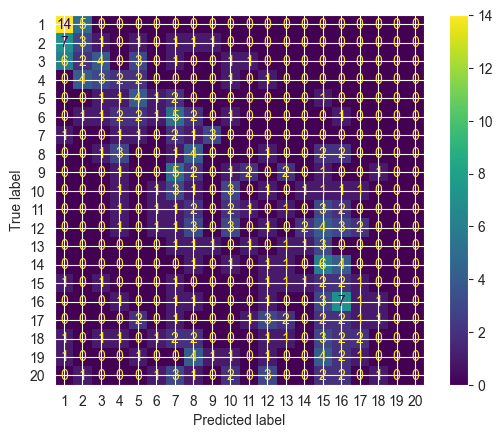

<Figure size 900x800 with 0 Axes>

In [29]:
cm = confusion_matrix(y_test, svm_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_+1
)
disp.plot()
plt.figure(figsize=(9,8))
plt.show()

### Dokładność

In [30]:
svm_accuracy = accuracy_score(y_test, svm_pred)

print("Wartość dokładności: {:.3f}".format(svm_accuracy))

Wartość dokładności: 0.171


### Zmodyfikowana dokładność

Przy 20 różnych klasach ciężko jest przewidzieć wynik co do klasy, dlatego postanowiłem dodatkowo sprawdzić dokładność w trochę inny sposób. Mianowicie, jeżeli model pomyli się o jedną pozycję (w górę lub w dół) chcę go nagradzać połową punktów.

In [31]:
def modified_accuracy(y_test, y_pred):
    num_errors = sum(y_true != y_pred for y_true, y_pred in zip(y_test, y_pred))
    num_one_off_errors = sum(abs(y_true - y_pred) == 1 for y_true, y_pred in zip(y_test, y_pred))
    return (len(y_test) - num_errors + 0.5 * num_one_off_errors) / len(y_test)

svm_modified_accuracy = modified_accuracy(y_test, svm_pred)
print("Wartość zmodyfikowanej dokładności: {:.3f}".format(svm_modified_accuracy))

Wartość zmodyfikowanej dokładności: 0.267


## Random Forrest

### Macierz Pomyłek

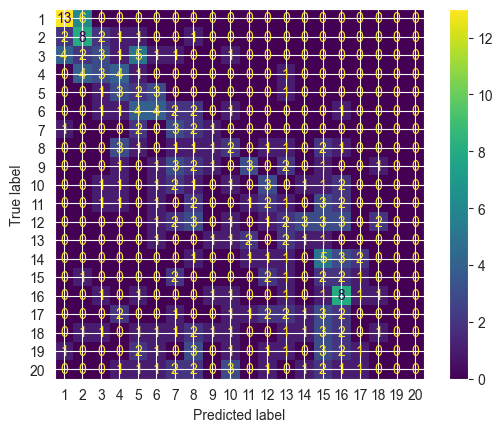

<Figure size 900x800 with 0 Axes>

In [32]:
cm = confusion_matrix(y_test, rf_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_+1
)
disp.plot()
plt.figure(figsize=(9,8))
plt.show()

### Dokładność

In [33]:
rf_accuracy = accuracy_score(y_test, rf_pred)

print("Wartość dokładności: {:.3f}".format(rf_accuracy))

Wartość dokładności: 0.188


### Zmodyfikowana Dokładność

In [34]:
rf_modified_accuracy = modified_accuracy(y_test, rf_pred)
print("Wartość zmodyfikowanej dokładności: {:.3f}".format(rf_modified_accuracy))

Wartość zmodyfikowanej dokładności: 0.277


## K-Nearest Neighbors

### Macierz pomyłek

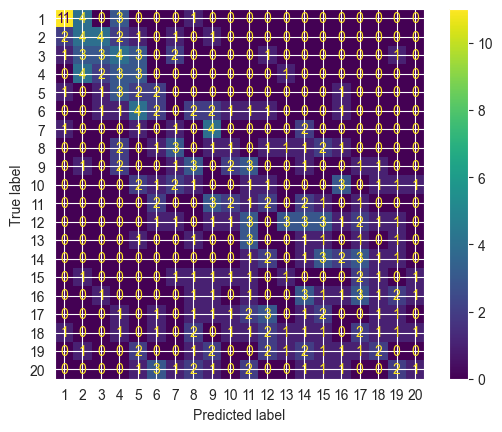

<Figure size 900x800 with 0 Axes>

In [35]:
cm = confusion_matrix(y_test, knn_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_+1
)
disp.plot()
plt.figure(figsize=(9,8))
plt.show()

### Dokładność

In [36]:
knn_accuracy = accuracy_score(y_test, knn_pred)

print("Wartość dokładności: {:.3f}".format(knn_accuracy))

Wartość dokładności: 0.106


### Zmodyfikowana dokładność

In [37]:
knn_modified_accuracy = modified_accuracy(y_test, knn_pred)
print("Wartość zmodyfikowanej dokładności: {:.3f}".format(knn_modified_accuracy))

Wartość zmodyfikowanej dokładności: 0.221


# Posumowanie

In [38]:
results = []
results.append(("SVM", svm_accuracy, svm_modified_accuracy))
results.append(("Random Forrest", rf_accuracy, rf_modified_accuracy))
results.append(("K-Nearest Neighbors", knn_accuracy, knn_modified_accuracy))
df = pd.DataFrame(results, columns=['Model', 'Dokładność', "Z.Dokładność"])
print(df)

                 Model  Dokładność  Z.Dokładność
0                  SVM    0.171233      0.267123
1       Random Forrest    0.188356      0.277397
2  K-Nearest Neighbors    0.106164      0.220890


Najgorzej z trzech zastosowanych modeli poradził sobie K-Nearest Neighbors. Modele SVM i Random Forrest poradziły sobie podobnie. SVM był najbardziej dokładny ze wszystkich modeli, natomiast Random Forrest nadrobił w stosunku do niego większą ilością drobnych pomyłek. W ogólnym rozrachunku jestem zadowolony z wyników. Jak na tak dużą ilość klas modele poradziły sobie dość dobrze, zwłaszcza że w rzeczywistości w Formule 1 jest dużo losowości, a dokładne wyniki jest bardzo ciężko przewidzieć.

### Potencjalne poprawki

Wyniki w dużej mierze zależały od podanych parametrów modeli. Dla każdego modelu sprawdzałem uzyskane wyniki podając różnorodne wartości parametrów. Istnieje jednak prawdopodobieństwo, że istnieje kombinacja parametrów, która daje jeszcze lepszy rezultat.